## **Implementing Word2Vec from Scratch**

Let's download the IMDB dataset in raw format.

In [2]:
import tensorflow as tf
from tensorflow import keras
import os, pathlib, shutil, random

zip_path = keras.utils.get_file(
    origin="https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz",
    fname="imdb",
    extract=True,
)

imdb_extract_dir = pathlib.Path(zip_path) / "aclImdb"

print(open(imdb_extract_dir / "train" / "pos" / "4077_10.txt", "r").read())

84125825/84125825 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Make a TextVectorization layer that integer encodes all words in the IMDB data.

In [36]:
from keras import layers

# The underscore is ignored by Python and just makes the number easier to read :).
max_tokens = 20_000

# Make a TF dataset object using the text files in the training directory.
dataset = keras.utils.text_dataset_from_directory(
    imdb_extract_dir / "train", batch_size=None
)

# Pull out the text alone (drop the labels)
text_dataset = dataset.map(lambda text,label: text,num_parallel_calls=8)

# Make a text vectorization layer that will encode integer sequences for the 20,000 most common terms.
tokenize_no_padding = layers.TextVectorization(
    max_tokens=max_tokens,
    split="whitespace",
    output_mode="int",
)

tokenize_no_padding.adapt(text_dataset)

Found 75000 files belonging to 3 classes.


Define functions we can use against the Tensorflow Dataset object to parse out observations (context words + predicted word labels).

In [37]:
# We will look at 4 words on either side of a given word and we will try to predict them!
# 4 + word + 4 = 9 word window.
context_size = 4
window_size = 9

# We are going to iterate over the text in our sample to make training observations.
def window_data(token_ids):
    num_windows = tf.maximum(tf.size(token_ids) - context_size * 2, 0)
    windows = tf.range(window_size)[None, :]
    windows = windows + tf.range(num_windows)[:, None]
    windowed_tokens = tf.gather(token_ids, windows)
    return tf.data.Dataset.from_tensor_slices(windowed_tokens)

# The 5th observation (0 indexed) will be our label.
def split_label(window):
    left = window[:context_size]
    right = window[context_size + 1:]
    bag = tf.concat((left, right), axis=0)
    label = window[4]
    return bag, label

# Apply the Text Vectorizer to our data
dataset = text_dataset.map(tokenize_no_padding, num_parallel_calls=8)

# Apply the sample construction function (pull out 9 words at a time in sequence, for all possible sequences).
dataset = dataset.interleave(window_data, num_parallel_calls=8)

# Pull out our labels vs. context windows.
dataset = dataset.map(split_label, num_parallel_calls=8)

Define structure of our Neural Network

In [38]:
hidden_dim = 64

# We have 8 input tokens (surrounding the predicted word, which is our label)
inputs = keras.Input(shape=(2 * context_size,))

# We get the embeddings for each of those 8 words.
# Eventually the embeddings we learn here can be useful elsewhere!
cbow_embedding = layers.Embedding(
    max_tokens,
    hidden_dim,
)
x = cbow_embedding(inputs)

# We then Average the embeddings to end up with a vector output
x = layers.GlobalAveragePooling1D()(x)

# We then put those into big softmax (20,000 nodes, one per word in our vocab)
outputs = layers.Dense(max_tokens, activation="softmax")(x)

cbow_model = keras.Model(inputs, outputs)

cbow_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)

cbow_model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_7 (Embedding)              │ (None, 8, 64)               │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_7           │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 20000)               │       1,300,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,580,000 (9.84 MB)

 Trainable params: 2,580,000 (9.84 MB)

 Non-trainable params: 0 (0.00 B)

Finally, let's fit the model...

Fit the Neural Net to our data. We achieve about 15% accuracy, eventually. Note that we don't need a super high predictive performance for the embeddings to be useful. We also are not super worried about overfitting here.  

In [39]:
dataset = dataset.batch(1024).cache()
cbow_model.fit(dataset, epochs=6)

Epoch 1/6
16503/16503 ━━━━━━━━━━━━━━━━━━━━ 280s 17ms/step - loss: 6.5429 - sparse_categorical_accuracy: 0.0856
Epoch 2/6
16503/16503 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - loss: 5.8316 - sparse_categorical_accuracy: 0.1282
Epoch 3/6
16503/16503 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - loss: 5.6686 - sparse_categorical_accuracy: 0.1357
Epoch 4/6
16503/16503 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - loss: 5.5942 - sparse_categorical_accuracy: 0.1380
Epoch 5/6
16503/16503 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - loss: 5.5506 - sparse_categorical_accuracy: 0.1390
Epoch 6/6
16503/16503 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - loss: 5.5217 - sparse_categorical_accuracy: 0.1396


And now we can extract the embeddings for specific words and show that they really do capture semantic meaning!

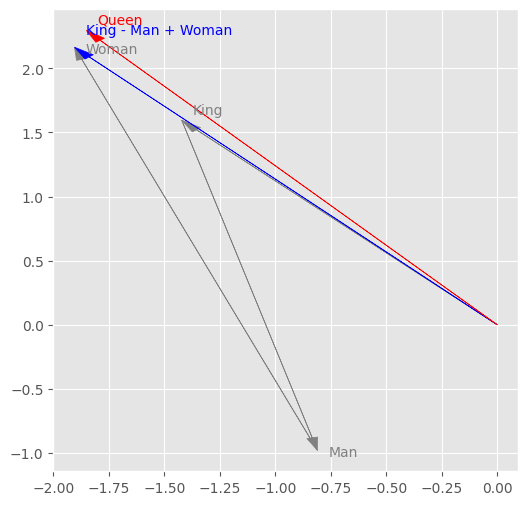

In [49]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Get the embedding layer from the CBOW model
embedding_layer = cbow_model.get_layer('embedding_7')

# Get the vocabulary (word-to-index mapping)
vocab = tokenize_no_padding.get_vocabulary()

# Function to get the vector representation of a word
def get_word_vector(word):
  word_index = vocab.index(word)
  return embedding_layer(tf.constant([word_index])).numpy()[0]

# Get the vector representations for the desired words
king_vector = get_word_vector('king')
queen_vector = get_word_vector('queen')
man_vector = get_word_vector('man')
woman_vector = get_word_vector('woman')

# Calculate the "King - Man + Woman" vector
result_vector = king_vector - man_vector + woman_vector

# Initialize PCA and fit it to the embedding space
# We are fitting on the embedding layer weights to learn the principal components
pca = PCA(n_components=2)
pca.fit(embedding_layer.get_weights()[0]) # Get weights from the embedding layer

## Reduce vectors to 2D using PCA
result_vector_2d = pca.transform(np.array([result_vector]))[0]
queen_vector_2d = pca.transform(np.array([queen_vector]))[0]
king_vector_2d = pca.transform(np.array([king_vector]))[0]
man_vector_2d = pca.transform(np.array([man_vector]))[0]
woman_vector_2d = pca.transform(np.array([woman_vector]))[0]

# Apply ggplot style
plt.style.use('ggplot')

# Plot the vectors as lines with arrows
plt.figure(figsize=(6, 6))

# Plot King vector
plt.arrow(0, 0, king_vector_2d[0], king_vector_2d[1], head_width=0.05, head_length=0.1, fc='gray', ec='gray', length_includes_head=True)
plt.text(king_vector_2d[0] + 0.05, king_vector_2d[1] + 0.05, 'King', color='gray') # Adjusted label position

# Plot Man vector, starting from King's tip (subtraction)
plt.arrow(king_vector_2d[0], king_vector_2d[1], -man_vector_2d[0], -man_vector_2d[1], head_width=0.05, head_length=0.1, fc='gray', ec='gray', length_includes_head=True)
plt.text(king_vector_2d[0] - man_vector_2d[0] + 0.05, king_vector_2d[1] - man_vector_2d[1] -0.05, 'Man', color='gray') # Adjusted label position


# Plot Woman vector, starting from King - Man's tip (addition)
plt.arrow(king_vector_2d[0] - man_vector_2d[0], king_vector_2d[1] - man_vector_2d[1], woman_vector_2d[0], woman_vector_2d[1], head_width=0.05, head_length=0.1, fc='gray', ec='gray', length_includes_head=True)
plt.text(result_vector_2d[0] + 0.05, result_vector_2d[1] - 0.05, 'Woman', color='gray') # Adjusted label position

# Plot "King - Man + Woman" vector (resultant)
plt.arrow(0, 0, result_vector_2d[0], result_vector_2d[1], head_width=0.05, head_length=0.1, fc='blue', ec='blue', length_includes_head=True)
plt.text(result_vector_2d[0] + 0.05, result_vector_2d[1] + 0.1, 'King - Man + Woman', color='blue') # Adjusted label position

# Plot "Queen" vector
plt.arrow(0, 0, queen_vector_2d[0], queen_vector_2d[1], head_width=0.05, head_length=0.1, fc='red', ec='red', length_includes_head=True)
plt.text(queen_vector_2d[0] + 0.05, queen_vector_2d[1] + 0.05, 'Queen', color='red')  # Adjusted label position

plt.show()